# **thread_cache_size란?**

- mysql은 Thread방식의 아키텍처로 설계되어 있으며, Clinet가 접속하게 되면 Thread를 할당해주고 접속이 종료되면 할당했던 Thread를 제거
- Client가 접속할 때마다 Thread를 할당하고 제거하는 작업은 Mysql 서버에서는 리소스 낭비 및 성능 저하를 발생시켜 주기적인 모니터링이 필요
- 즉, 스레드를 생성하고 해제할 때 메모리를 할당하고 캐시할 메모리를 미리 생성해놓고 적절하게 관리하는 용도
  - 커넥션이 종료되었을 때 thread를 바로 반납하지 않고 cache 영역에 keep해두고 나중에 신규 커넥션이 들어오면 thread를 바로 할당.
  - 순간 커넥션이 급증하는 시스템에서는 thread를 신규로 생성하지 않고 재사용 하므로 자원을 효율적으로 사용할.


**thread_cache_size의 기본값 공식**

- 8 + (max_connections / 100)

**status를 보고 cache 히트율을 판단해 보는 것이 좋음.**

-  select (1 - (@Threads_created / @Connections )) * 100 as "Threads_created % of Connections"\G



**my.cnf thread_cache_size 확인**


```
cd /etc/mysql/mysql.conf.d #ubuntu 기준
vim mysqld.cnf
```

### **thread_cache_size가 -1 로 설정된 이유?**
- thread_cache_size를 -1로 설정하면 MySQL에서는 자동으로 thread_cache_size를 결정하는 것으로 설정
- 이는 현재의 작업 부하, 시스템 자원 상태를 고려하여 최적의 thread_cache_size를 결정하려 할 때 사용
- 단, 특정 상황이나 세부 조정이 필요한 경우에는 조절 필요



**global status 확인**


```
show global status like "%threads_%";
```



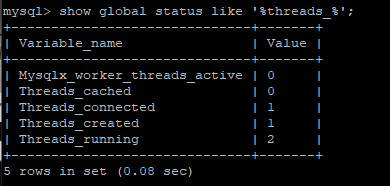

- Threads_cached : 스레드 캐시에 있는 스레드 수
- Threads_connected : 현재 오픈된 스레드 수
- Threads_created : 연결을 다루기 위해 생성된 스레드 수
- Threads_runnging : sleep상태가 아닌 실행되고 있는 Thread 수


> ex. 현재 Threads_created =4 / Threads_connected =4 이다. 이상태에서 Thread_connected =2로 줄게되면 Threads_created=4 / Threads_connected=2 / Threads_cached =2 가 됨.
>
> - 생성되고 남은 Thread는 Cache로 반납.

**튜닝 방법**

**1. Threads_cache_size 변경**

- Thread_created 변수가 증가하는 경우 Thread_cache_size값을 증가 필요
- connection을 미리 만들어 Client가 접속할 시 Thread를 만들지 않고 cache의 Thread를 사용자에게 할당
- cache의 Thread를 사용하게 되면서 만드는 부하를 감소시키는 장점 보유

**2. cache miss ratio**

- 캐시 메모리의 성능을 평가하고 최적화하기 위한 지표로 cache에서 요청한 데이터가 cache에 존재하지 않고 주 메모리나 다른 하위 수준의 cache로부터 가져와야 할 때 발생하는 빈도
- cache miss ratio는 Threads_created / Connections * 100으로 계산하며 이 때 cache miss ratio가 낮은것이 좋음
- 이 비율을 낮추려면 thread_cache_size를 늘려야 하지만 이 값을 늘리면 시스템에 메모리를 많이 사용
- 반대로 너무 낮으면 thread를 계속 생성하여 시스템 추가 부하 발생
- 일반적으로 Threads_connected Paek-time시 보다 약간 낮은 수치로 설정하는것이 좋음
- Threads_connected의 수 100 ~ 120 : 캐시 크기 : 약 20
- Threads_connected의 수 500 ~ 700 : 캐시 크기 : 약 200


**Threads_튜닝시 성능 확인 지표**

```sql

show variables like '%thread_cache_size%';

show status like 'connections';

show status like '%threads_%';
```

**고려사항**


**성능 영향**
- 스레드 캐시 크기와 메모리 사용량의 균형을 맞추는 것.
- 캐시가 너무 작으면 스레드가 자주 생성되고, 캐시가 너무 크면 비례적인 이점 없이 더 많은 메모리를 소비.

**Threads_created 변수**
- MySQL/MariaDB의 이 지표는 서버가 시작된 이후 생성된 스레드 수를 나타냄.
- 값이 높으면 서버가 새 스레드를 자주 생성한다는 의미이며, 이는 thread_cache_size가 너무 낮다는 신호일 수 있음.

**시스템 리소스**
- 메모리 및 CPU와 같은 특정 시스템 리소스를 고려하십시오. 캐시가 클수록 더 많은 메모리가 필요.

**서버 로드**
- 트래픽이 많은 서버는 캐시 크기가 클수록 이점을 얻을 수 있음.

**일반 지침**
- 일반적인 경험 법칙은 thread_cache_size를 일반적인 동시 연결 수를 처리할 수 있는 값으로 설정하는 것.
 - 예를 들어 서버에 일반적으로 약 100개의 동시 연결이 있는 경우 thread_cache_size를 100 이상으로 설정하는 것이 좋은 시작점이 될 수 있음.

- 효율적인 결과를 보장하려면 Connections와 Threads_created 간의 차이점을 검사해야 함.
- 이러한 상태 변수는 thread_cache_size 값이 정확한지 여부를 보여줌.